# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [136]:
# Load libraries in specific order for learning purposes 
# Environment Handling
%load_ext dotenv
%dotenv 
import os
import sys

# Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data Handling Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer

# Preprocessing Libraries
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipelines
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


# Model Evaluation Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# Add the source directory to the system path
sys.path.append(os.getenv('SRC_DIR'))


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [137]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]

fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [138]:
# Display the first few rows of the dataset
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


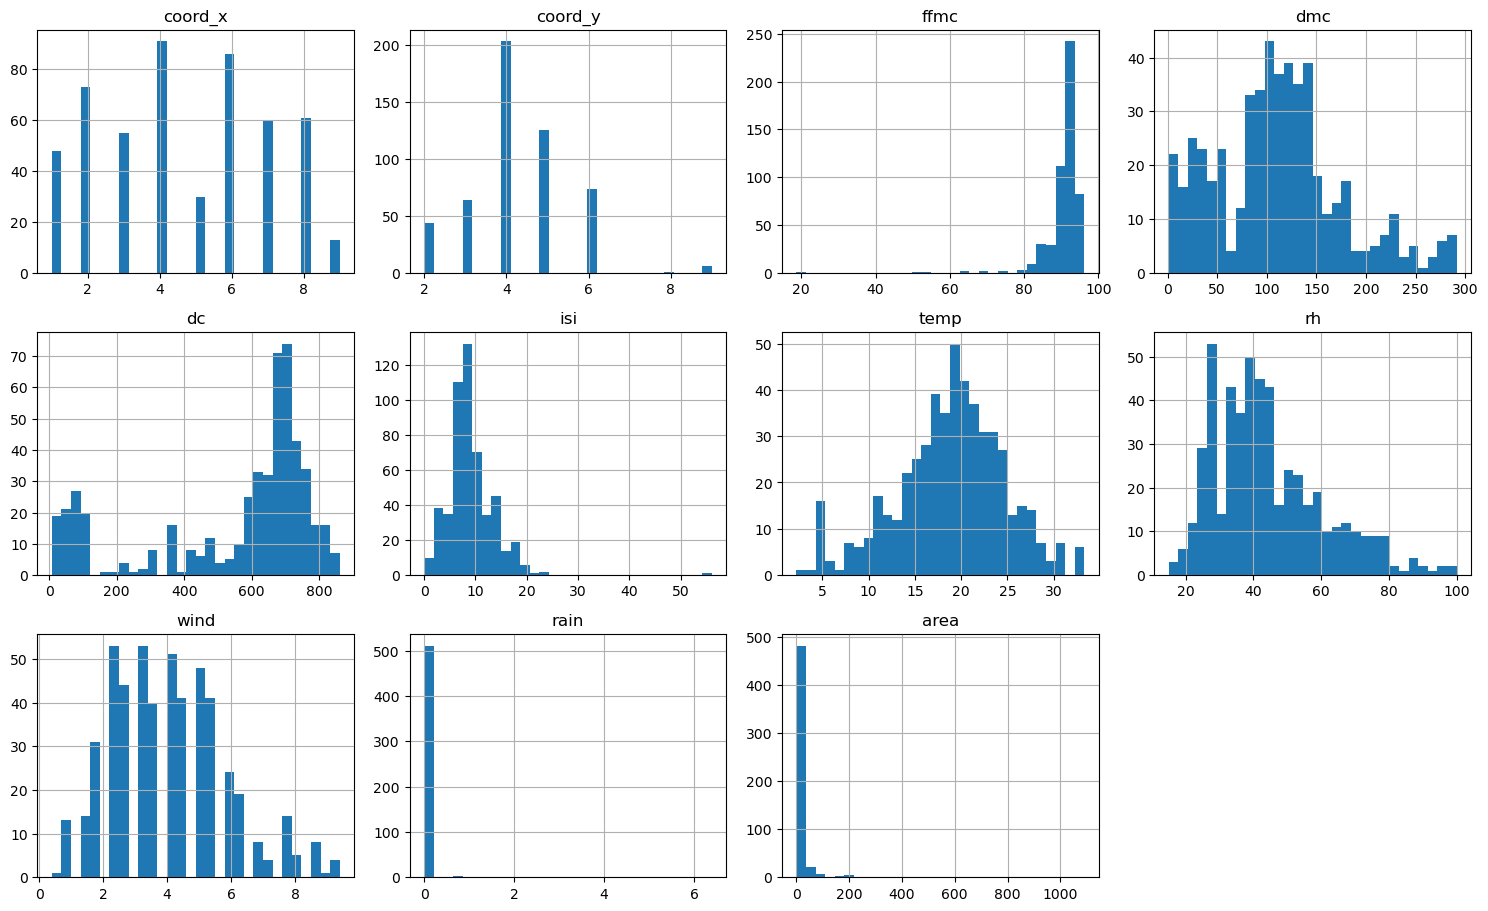

In [139]:
# Visualize the distribution of numeric features
numeric_cols = fires_dt.select_dtypes(include='number').columns

# Set up subplots
fires_dt[numeric_cols].hist(bins=30, figsize=(15, 12), layout=(4, 4))
plt.tight_layout()
plt.show()

# Get X and Y

Create the features data frame and target data.

In [140]:
# Create the features DataFrame
X = fires_dt.drop(columns=['area','day','coord_x', 'coord_y','isi','ffmc'])

# Get Y (dependent variable) 
Y = fires_dt['area']

# Display the first few rows of the features DataFrame
X.head()


,month,dmc,dc,temp,rh,wind,rain
0,mar,26.2,94.3,8.2,51,6.7,0.0
1,oct,35.4,669.1,18.0,33,0.9,0.0
2,oct,43.7,686.9,14.6,33,1.3,0.0
3,mar,33.3,77.5,8.3,97,4.0,0.2
4,mar,51.3,102.2,11.4,99,1.8,0.0


In [141]:
X.describe()

,dmc,dc,temp,rh,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,110.872340,547.940039,18.889168,44.288201,4.017602,0.021663
std,64.046482,248.066192,5.806625,16.317469,1.791653,0.295959
min,1.100000,7.900000,2.200000,15.000000,0.400000,0.000000
25%,68.600000,437.700000,15.500000,33.000000,2.700000,0.000000
50%,108.300000,664.200000,19.300000,42.000000,4.000000,0.000000
75%,142.400000,713.900000,22.800000,53.000000,4.900000,0.000000
max,291.300000,860.600000,33.300000,100.000000,9.400000,6.400000


In [142]:
# A quick check for missing values
print(fires_dt.isnull().sum().sum())

0


In [143]:
# Inspect data
numerical_features = X.select_dtypes(include='number').columns.tolist()
num_stats = pd.DataFrame(index=numerical_features)

num_stats['Skewness'] = X[numerical_features].skew()
num_stats['Kurtosis'] = X[numerical_features].kurtosis()
num_stats['Min'] = X[numerical_features].min()
num_stats['Max'] = X[numerical_features].max()

def suggest_transform(row):
    if abs(row['Skewness']) > 0.5 and row['Max'] > 20 and row.name not in ['ffmc', 'rh']:
        return 'YES'
    return 'NO'

num_stats['Apply_Log'] = num_stats.apply(suggest_transform, axis=1)
display(num_stats)

,Skewness,Kurtosis,Min,Max,Apply_Log
dmc,0.547498,0.204822,1.1,291.3,YES
dc,-1.100445,-0.245244,7.9,860.6,YES
temp,-0.331172,0.136166,2.2,33.3,NO
rh,0.862904,0.438183,15.0,100.0,NO
wind,0.571001,0.054324,0.4,9.4,NO
rain,19.816344,421.295964,0.0,6.4,NO


In [144]:
# Inspect target variable Y
# Calculates skewness, kurtosis, min, max, and suggests log transformation
y_stats = pd.DataFrame({
    'Skewness': [Y.skew()],
    'Kurtosis': [Y.kurt()],
    'Min': [Y.min()],
    'Max': [Y.max()]
}, index=['area'])

# Apply rule-based decision logic
def suggest_y_transform(row):
    if abs(row['Skewness']) > 0.5 and row['Max'] > 20:
        return 'YES'
    else:
        return 'NO'

y_stats['Log_Transform?'] = y_stats.apply(suggest_y_transform, axis=1)

# Display the diagnostic
display(y_stats)

,Skewness,Kurtosis,Min,Max,Log_Transform?
area,12.846934,194.140721,0.0,1090.84,YES


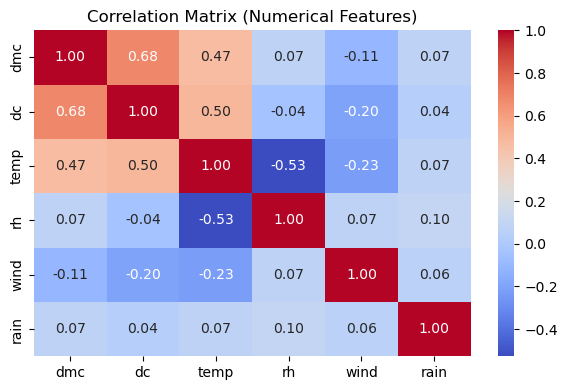

In [145]:
# Check for multicollinearity
plt.figure(figsize=(6,4))
sns.heatmap(X[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()

In [146]:
# Calculate multicolinearity using Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Select only numerical features
numerical_X = fires_dt.select_dtypes(include=[np.number]).drop(columns=['area'])

# Add a constant column for statsmodels
numerical_X_const = sm.add_constant(numerical_X)

# Create a DataFrame to hold VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_X_const.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_X_const.values, i)
                   for i in range(numerical_X_const.shape[1])]

# Display VIF values
vif_data

,Feature,VIF
0,const,507.885686
1,coord_x,1.433429
2,coord_y,1.445610
3,ffmc,1.698060
4,dmc,2.361567
5,dc,2.125930
6,isi,1.579370
7,temp,2.666717
8,rh,1.913799
9,wind,1.142779


In [147]:
fires_dt.describe()

,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [148]:
# Categorical features to retain
categorical_features = ['month']

# Numerical features: everything else that is not in categorical
numerical_features = [col for col in X.columns if col not in categorical_features and col != 'area']

In [149]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [150]:
# Transform the target variable Y using log transformation
Y_train_log = np.log1p(Y_train)
Y_test_log = np.log1p(Y_test)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [151]:
#Define the final numerical and categorical features for preprocessing
categorical_features = ['month']
numerical_features = X.drop(columns=categorical_features).columns.tolist()

# Define the preprocessing pipeline
preproc1 = ColumnTransformer(transformers=[
    ('num', RobustScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [152]:
# Apply log transformation to selected numerical features
transform_features = ['dmc', 'dc']
X_train_log = X_train.copy()
X_test_log = X_test.copy()
X_train_log[transform_features] = np.log1p(X_train_log[transform_features])
X_test_log[transform_features] = np.log1p(X_test_log[transform_features])

# Recreate list of updated numerical features (after dropping PCA)
numerical_features_log = X_train_log.drop(columns=categorical_features).columns.tolist()

# ColumnTransformer without PCA
preproc2 = ColumnTransformer(transformers=[
    ('num', RobustScaler(), numerical_features_log),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [153]:
# Pipeline A: preproc1 + baseline model (Ridge)
pipeline_a = Pipeline([
    ('preproc', preproc1),  
    ('model', Ridge(alpha=10.0, random_state=42))
])
pipeline_a

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['dmc', 'dc', 'temp', 'rh',
                                                   'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month'])])),
                ('model', Ridge(alpha=10.0, random_state=42))])

In [154]:
# Fit the model on log-transformed Y
pipeline_a.fit(X_train, Y_train_log)

# Predict on test set
Y_pred_log_a = pipeline_a.predict(X_test)

# Reverse log-transform to compare with original scale
Y_pred_a = np.expm1(Y_pred_log_a)

# Evaluate on original Y_test
mae_a = mean_absolute_error(Y_test, Y_pred_a)
rmse_a = np.sqrt(mean_squared_error(Y_test, Y_pred_a))

# Store results for summary
final_metrics_a = {
    'Pipeline': 'A (Ridge, preproc1, log Y)',
    'MAE': mae_a,
    'RMSE': rmse_a
}
# Print metrics
print(f"MAE: {mae_a:.2f}")
print(f"RMSE: {rmse_a:.2f}")


MAE: 16.65
RMSE: 98.34


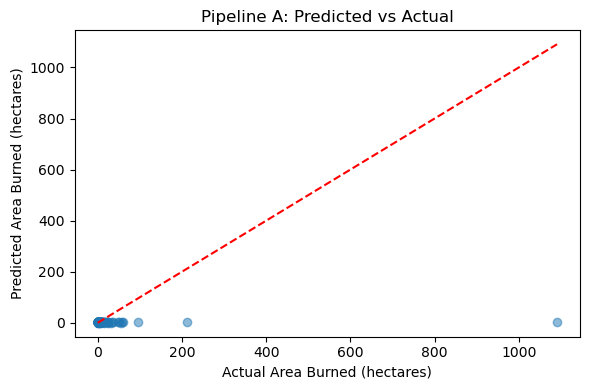

In [155]:
# Visualize the predictions vs actual values for Pipeline A
plt.figure(figsize=(6, 4))
plt.scatter(Y_test, Y_pred_a, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Area Burned (hectares)")
plt.ylabel("Predicted Area Burned (hectares)")
plt.title("Pipeline A: Predicted vs Actual")
plt.tight_layout()
plt.show()

In [156]:
# Pipeline B = preproc2 + baseline

pipeline_b = Pipeline([
    ('preproc', preproc2),
    ('model', Lasso(alpha=0.01, random_state=42, max_iter=10000))
])
pipeline_b

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['dmc', 'dc', 'temp', 'rh',
                                                   'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month'])])),
                ('model', Lasso(alpha=0.01, max_iter=10000, random_state=42))])

In [157]:
# Fit the pipeline with log-transformed data
pipeline_b.fit(X_train_log, Y_train_log)

# Predict on test set
Y_pred_log_b = pipeline_b.predict(X_test_log)

# Inverse transform the predictions
Y_pred_b = np.expm1(Y_pred_log_b)

# Evaluate
mae_b = mean_absolute_error(Y_test, Y_pred_b)
rmse_b = np.sqrt(mean_squared_error(Y_test, Y_pred_b))

# Store the results for later use in a comparison table
final_metrics_b = {
    'Pipeline': 'B (Lasso, preproc2)',
    'MAE': mae_b,
    'RMSE': rmse_b
}

# Print metrics
print("Pipeline B - Lasso with log-transformed Y")
print(f"MAE: {mae_b:.2f}")
print(f"RMSE: {rmse_b:.2f}")

Pipeline B - Lasso with log-transformed Y
MAE: 16.63
RMSE: 98.36


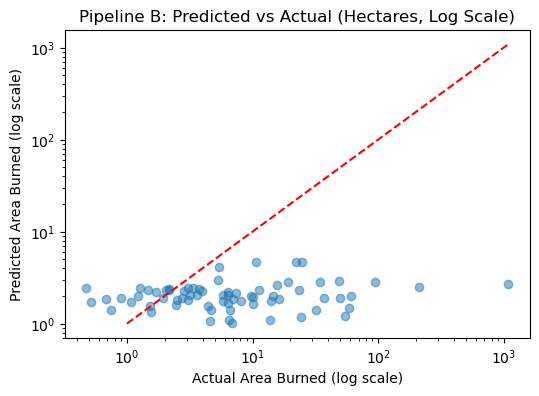

In [158]:
# Visualize predictions vs actual values for Pipeline B
plt.figure(figsize=(6, 4))
plt.scatter(Y_test, Y_pred_b, alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.plot([1, max(Y_test)], [1, max(Y_test)], color='red', linestyle='--')
plt.xlabel("Actual Area Burned (log scale)")
plt.ylabel("Predicted Area Burned (log scale)")
plt.title("Pipeline B: Predicted vs Actual (Hectares, Log Scale)")
plt.show()

In [159]:
# Pipeline C = preproc1 + advanced model (Random Forest)
pipeline_c = Pipeline([
    ('preproc', preproc1),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=5,
        random_state=42
    ))
])
pipeline_c

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['dmc', 'dc', 'temp', 'rh',
                                                   'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, n_estimators=300,
                                       random_state=42))])

In [160]:
# Fit on X and Y
pipeline_c.fit(X_train, Y_train_log)

# Predict on test set
Y_pred_log_c = pipeline_c.predict(X_test)

# Inverse transform the prediction to original scale
Y_pred_c = np.expm1(Y_pred_log_c)

# Evaluate
mae_c = mean_absolute_error(Y_test, Y_pred_c)
rmse_c = np.sqrt(mean_squared_error(Y_test, Y_pred_c))

# Store results
final_metrics_c = {
    'Pipeline': 'C (RandomForest, preproc1)',
    'MAE': mae_c,
    'RMSE': rmse_c
}

# Print metrics
print(f"MAE: {mae_c:.2f}")
print(f"RMSE: {rmse_c:.2f}")

MAE: 16.54
RMSE: 98.31


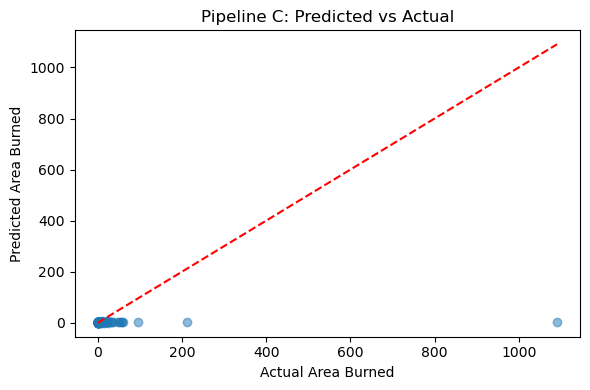

In [161]:
# Visualize predictions vs actual values for Pipeline C
plt.figure(figsize=(6, 4))
plt.scatter(Y_test, Y_pred_c, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Area Burned")
plt.ylabel("Predicted Area Burned")
plt.title("Pipeline C: Predicted vs Actual")
plt.tight_layout()
plt.show()

In [162]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preproc', preproc2),
    ('model', DecisionTreeRegressor(
        max_depth = 3,
        min_samples_leaf = 1,
        min_samples_split = 5,
        random_state=42))
])
pipeline_d

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['dmc', 'dc', 'temp', 'rh',
                                                   'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=3, min_samples_split=5,
                                       random_state=42))])

In [163]:
# Fit on the log-transformed training data
pipeline_d.fit(X_train_log, Y_train_log)

# Predict on the log-transformed test set
Y_pred_log_d = pipeline_d.predict(X_test_log)

# Reverse log-transform to compare on original scale
Y_pred_d = np.expm1(Y_pred_log_d)

# Evaluate performance
mae_d = mean_absolute_error(Y_test, Y_pred_d)
rmse_d = np.sqrt(mean_squared_error(Y_test, Y_pred_d))

# Store the results
final_metrics_d = {
    'Pipeline': 'D (DecisionTree, preproc2)',
    'MAE': mae_d,
    'RMSE': rmse_d
}

print(f"MAE: {mae_d:.2f}")
print(f"RMSE: {rmse_d:.2f}")

MAE: 16.43
RMSE: 97.82


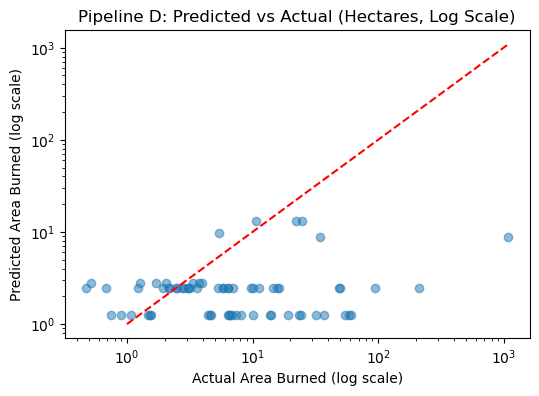

In [164]:
# Visualize predictions vs actual values for Pipeline D
plt.figure(figsize=(6, 4))
plt.scatter(Y_test, Y_pred_d, alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.plot([1, max(Y_test)], [1, max(Y_test)], color='red', linestyle='--')
plt.xlabel("Actual Area Burned (log scale)")
plt.ylabel("Predicted Area Burned (log scale)")
plt.title("Pipeline D: Predicted vs Actual (Hectares, Log Scale)")
plt.show()

In [165]:
importances = pipeline_d.named_steps['model'].feature_importances_
features = pipeline_d.named_steps['preproc'].get_feature_names_out()
pd.Series(importances, index=features).sort_values(ascending=False).head(10)

num__dmc          0.404875
cat__month_dec    0.237109
num__temp         0.188473
num__dc           0.169543
cat__month_jul    0.000000
cat__month_oct    0.000000
cat__month_nov    0.000000
cat__month_may    0.000000
cat__month_mar    0.000000
cat__month_jun    0.000000
dtype: float64

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [166]:
# Define parameter grid for Pipeline A : Lasso alpha tuning
param_grid_a = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Set up GridSearchCV
grid_a = GridSearchCV(
    pipeline_a,
    param_grid=param_grid_a,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit on training data (Y is log-transformed)
grid_a.fit(X_train, Y_train_log)

# Get best estimator and evaluate on test set
best_pipeline_a = grid_a.best_estimator_
Y_pred_log_a = best_pipeline_a.predict(X_test)
Y_pred_a = np.expm1(Y_pred_log_a)

# Evaluate
mae_a = mean_absolute_error(Y_test, Y_pred_a)
rmse_a = np.sqrt(mean_squared_error(Y_test, Y_pred_a))

# Print results
print("Pipeline A - Best Params:", grid_a.best_params_)
print(f"Test MAE (Best Lasso): {mae_a:.2f}")
print(f"Test RMSE (Best Lasso): {rmse_a:.2f}")

Pipeline A - Best Params: {'model__alpha': 10.0}
Test MAE (Best Lasso): 16.65
Test RMSE (Best Lasso): 98.34


In [167]:
# Define parameter grid for Ridge
param_grid_b = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Grid search for Pipeline B
grid_b = GridSearchCV(pipeline_b, param_grid_b, cv=5, scoring='neg_mean_absolute_error')
grid_b.fit(X_train_log, Y_train_log)

# Best params and score
print("Pipeline B - Best Params:", grid_b.best_params_)
print("Pipeline B - Best MAE:", -grid_b.best_score_)

Pipeline B - Best Params: {'model__alpha': 0.01}
Pipeline B - Best MAE: 1.1440678616722044


In [168]:
# Define the param grid for tuning for Pipeline C (Random Forest)
param_grid_c = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, None],
}

# Setup GridSearchCV
grid_c = GridSearchCV(
    pipeline_c,
    param_grid=param_grid_c,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit on log-transformed training target
grid_c.fit(X_train, Y_train_log)

# Save the best model
best_pipeline_c = grid_c.best_estimator_

# Predict and inverse transform for final evaluation
Y_pred_log_c = best_pipeline_c.predict(X_test)
Y_pred_c = np.expm1(Y_pred_log_c)

# Evaluate
mae_c = mean_absolute_error(Y_test, Y_pred_c)
rmse_c = np.sqrt(mean_squared_error(Y_test, Y_pred_c))

# Show results
print("Pipeline C - Best Params:", grid_c.best_params_)
print("Pipeline C - Best CV MAE:", -grid_c.best_score_)
print(f"Test MAE (Best RandomForest): {mae_c:.2f}")
print(f"Test RMSE (Best RandomForest): {rmse_c:.2f}")

Pipeline C - Best Params: {'model__max_depth': 5, 'model__n_estimators': 300}
Pipeline C - Best CV MAE: 1.1739712245195382
Test MAE (Best RandomForest): 16.54
Test RMSE (Best RandomForest): 98.31


In [169]:
# Define parameter grid for Decision Tree
param_grid_d = {
    'model__max_depth': [3, 5, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_d = GridSearchCV(
    pipeline_d,
    param_grid=param_grid_d,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_d.fit(X_train_log, Y_train_log)

# Evaluate and display best params and test results
best_pipeline_d = grid_d.best_estimator_
Y_pred_log_d = best_pipeline_d.predict(X_test_log)
Y_pred_d = np.expm1(Y_pred_log_d)

print("Pipeline D - Best Params:", grid_d.best_params_)
print("Pipeline D - Best MAE (CV):", -grid_d.best_score_)

# Recalculate and print test metrics
mae_d = mean_absolute_error(Y_test, Y_pred_d)
rmse_d = np.sqrt(mean_squared_error(Y_test, Y_pred_d))
print(f"Test MAE (Best Decision Tree): {mae_d:.2f}")
print(f"Test RMSE (Best Decision Tree): {rmse_d:.2f}")

Pipeline D - Best Params: {'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}
Pipeline D - Best MAE (CV): 1.1805526805847484
Test MAE (Best Decision Tree): 16.43
Test RMSE (Best Decision Tree): 97.82


# Evaluate

+ Which model has the best performance?


In [170]:
# Collect results into a summary DataFrame
evaluation_df = pd.DataFrame({
    'Pipeline': [
        'A (Ridge Regression, preproc1)',
        'B (Lasso, preproc2)',
        'C (Random Forest, preproc1)',
        'D (Decision Tree, preproc2)'
    ],
    'MAE': [
        mean_absolute_error(Y_test, Y_pred_a),
        mean_absolute_error(Y_test, Y_pred_b),
        mean_absolute_error(Y_test, Y_pred_c),
        mean_absolute_error(Y_test, Y_pred_d)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(Y_test, Y_pred_a)),
        np.sqrt(mean_squared_error(Y_test, Y_pred_b)),
        np.sqrt(mean_squared_error(Y_test, Y_pred_c)),
        np.sqrt(mean_squared_error(Y_test, Y_pred_d))
    ]
})

# Format and sort by MAE
evaluation_df = evaluation_df.sort_values(by='MAE').reset_index(drop=True)
evaluation_df.style.format({'MAE': '{:.2f}', 'RMSE': '{:.2f}'})

,Pipeline,MAE,RMSE
0,"D (Decision Tree, preproc2)",16.43,97.82
1,"C (Random Forest, preproc1)",16.54,98.31
2,"B (Lasso, preproc2)",16.63,98.36
3,"A (Ridge Regression, preproc1)",16.65,98.34


In [171]:
# Evaluate pipeline A using cross-validation
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']

# Run cross-validation on the tuned pipeline_a
cv_results_a = cross_validate(
    pipeline_a,
    X_train,
    Y_train,
    cv=5,
    scoring=scoring,
    return_train_score=True
)

# Create a DataFrame for easier review
cv_df_a = pd.DataFrame({
    'Fold': range(1, 6),
    'Train MAE': -cv_results_a['train_neg_mean_absolute_error'],
    'Test MAE': -cv_results_a['test_neg_mean_absolute_error'],
    'Train RMSE': -cv_results_a['train_neg_root_mean_squared_error'],
    'Test RMSE': -cv_results_a['test_neg_root_mean_squared_error']
})

# Display
cv_df_a

,Fold,Train MAE,Test MAE,Train RMSE,Test RMSE
0,1,16.119467,18.847662,47.521533,41.894620
1,2,19.018409,12.592322,51.314539,16.146100
2,3,17.115616,15.808143,49.892915,28.373416
3,4,13.212543,23.743644,28.562116,87.437948
4,5,18.109100,14.321465,50.301615,25.354240


In [172]:
# Evaluate Pipeline B with cross-validation
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']

# Cross-validation for Pipeline B
cv_results_b = cross_validate(
    pipeline_b,
    X_train_log,
    Y_train_log,
    cv=5,
    scoring=scoring,
    return_train_score=True
)

# Format results into a DataFrame
cv_df_b = pd.DataFrame({
    'Fold': range(1, 6),
    'Train MAE': -cv_results_b['train_neg_mean_absolute_error'],
    'Test MAE': -cv_results_b['test_neg_mean_absolute_error'],
    'Train RMSE': -cv_results_b['train_neg_root_mean_squared_error'],
    'Test RMSE': -cv_results_b['test_neg_root_mean_squared_error'],
})

cv_df_b

,Fold,Train MAE,Test MAE,Train RMSE,Test RMSE
0,1,1.108295,1.203010,1.349430,1.450304
1,2,1.162201,0.975207,1.409054,1.166617
2,3,1.070347,1.279437,1.323638,1.524236
3,4,1.092350,1.220890,1.325253,1.519921
4,5,1.151004,1.041795,1.393359,1.257109


In [173]:
# EVALUATE Pipeline C with cross-validation
cv_results_c = cross_validate(
    pipeline_c,
    X_train,
    Y_train,
    cv=5,
    scoring=scoring,
    return_train_score=True
)

cv_df_c = pd.DataFrame({
    'Fold': range(1, 6),
    'Train MAE': -cv_results_c['train_neg_mean_absolute_error'],
    'Test MAE': -cv_results_c['test_neg_mean_absolute_error'],
    'Train RMSE': -cv_results_c['train_neg_root_mean_squared_error'],
    'Test RMSE': -cv_results_c['test_neg_root_mean_squared_error'],
})

cv_df_c


,Fold,Train MAE,Test MAE,Train RMSE,Test RMSE
0,1,10.907621,26.838132,23.981861,77.731933
1,2,12.875174,20.880164,25.907309,36.794276
2,3,11.778631,17.270748,26.393227,33.344953
3,4,8.883031,25.154707,16.198496,89.099364
4,5,12.419455,12.956044,25.390308,27.458578


In [174]:
# EVALUATE Pipeline D with cross-validation
cv_results_d = cross_validate(
    pipeline_d,
    X_train_log,
    Y_train_log,
    cv=5,
    scoring=scoring,
    return_train_score=True
)

cv_df_d = pd.DataFrame({
    'Fold': range(1, 6),
    'Train MAE': -cv_results_d['train_neg_mean_absolute_error'],
    'Test MAE': -cv_results_d['test_neg_mean_absolute_error'],
    'Train RMSE': -cv_results_d['train_neg_root_mean_squared_error'],
    'Test RMSE': -cv_results_d['test_neg_root_mean_squared_error'],
})

cv_df_d

,Fold,Train MAE,Test MAE,Train RMSE,Test RMSE
0,1,1.081811,1.200350,1.339246,1.473116
1,2,1.134403,1.078843,1.370375,1.315377
2,3,1.011240,1.293935,1.252165,1.554235
3,4,1.022006,1.286815,1.275537,1.578880
4,5,1.100401,1.042821,1.359671,1.292258


# Export

+ Save the best performing model to a pickle file.

In [175]:
import pickle

# Save the best-performing model (Pipeline D) to a pickle file
with open('best_pipeline_d_decisiontree.pkl', 'wb') as f:
    pickle.dump(pipeline_d, f)

print("Model saved as 'best_pipeline_d_decisiontree.pkl' in current directory.")

Model saved as 'best_pipeline_d_decisiontree.pkl' in current directory.


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

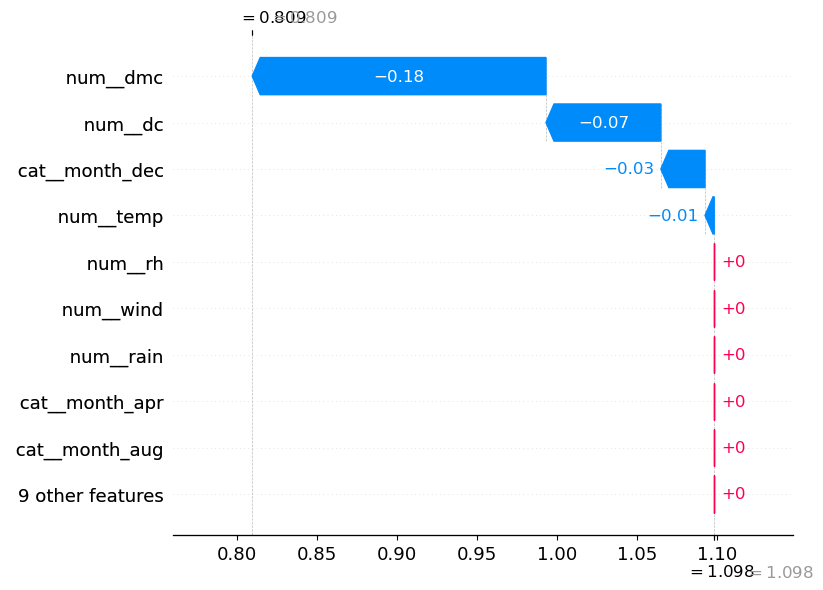

In [176]:
# Compatibility patch for SHAP with new NumPy versions
import numpy as np
if not hasattr(np, 'bool'):
    np.bool = bool

import shap

# Extract model and transformed test data
model_d = best_pipeline_d.named_steps['model']
preproc_d = best_pipeline_d.named_steps['preproc']
X_test_preproc_d = preproc_d.transform(X_test_log)

# Recreate DataFrame with feature names
X_test_df = pd.DataFrame(X_test_preproc_d, columns=preproc_d.get_feature_names_out())

# SHAP Explainer for Decision Tree (tree-based)
explainer = shap.TreeExplainer(model_d)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_df)

# Choose 1 row for local explanation
obs_idx = 0
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],          
    shap_values[obs_idx],                
    X_test_df.iloc[obs_idx],           
    feature_names=X_test_df.columns      
)


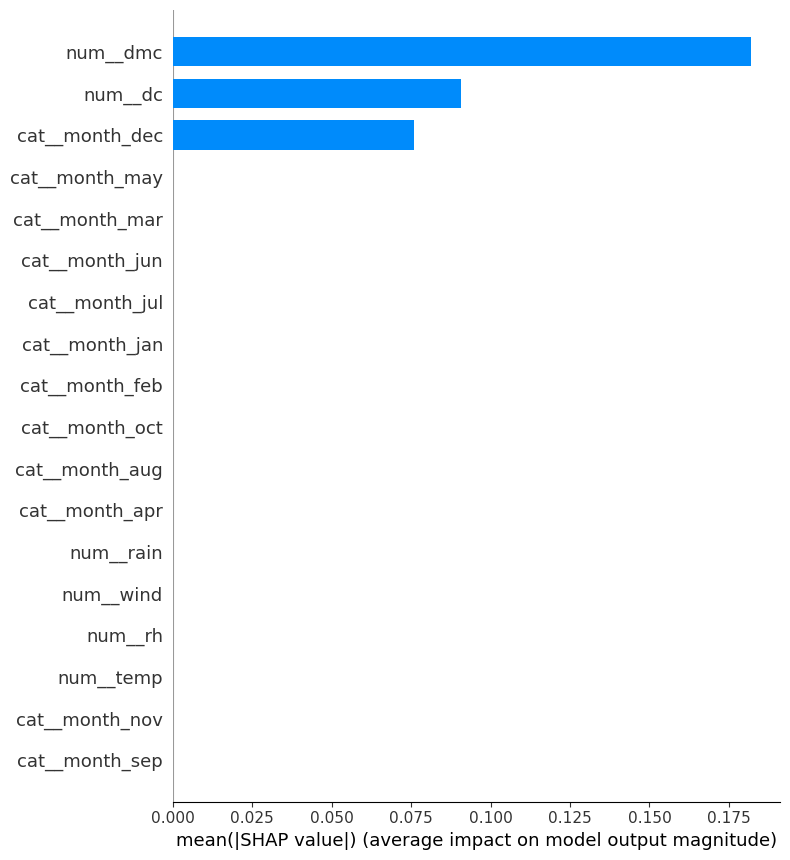

In [177]:
# Step 1: Extract model and preprocessor
model_d = best_pipeline_d.named_steps['model']
preproc_d = best_pipeline_d.named_steps['preproc']

# Step 2: Transform test set
X_test_preproc_d = preproc_d.transform(X_test_log)
X_test_df = pd.DataFrame(X_test_preproc_d, columns=preproc_d.get_feature_names_out())

# Step 3: Use SHAP TreeExplainer
explainer = shap.Explainer(model_d, X_test_df)

# Step 4: Compute SHAP values for the whole test set
shap_values_all = explainer(X_test_df)

# Step 5: Summary plot
shap.summary_plot(
    shap_values_all,
    features=X_test_df,
    plot_type="bar"
)

In [178]:
# Compute mean absolute SHAP value per feature
shap_importance = np.abs(shap_values_all.values).mean(axis=0)
importance_series = pd.Series(shap_importance, index=X_test_df.columns).sort_values()

# Show top 10 least important features
print("Least important features:")
print(importance_series.head(10))

Least important features:
cat__month_sep    0.0
cat__month_nov    0.0
num__temp         0.0
num__rh           0.0
num__wind         0.0
num__rain         0.0
cat__month_apr    0.0
cat__month_aug    0.0
cat__month_oct    0.0
cat__month_feb    0.0
dtype: float64


Answer: I would remove variables that do not have any signals showing that it influences the target variable such as the months but will retain those that could have significant interaction between variables

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.